# **Projeção da quantidade de requerimentos do Programa de Transferência de Renda às pessoas atingidas pelo rompimento da Barragem de Córrego do Feijão em Brumadinho**
O presente estudo de caso têm como objetivo descrever o desenvolvimento de um modelo de previsão de séries temporais em um cenário de relevância social: a projeção do número de requerimentos do Programa de Transferência de Renda (PTR)  às pessoas atingidas pelo rompimento da Barragem de Córrego do Feijão em Brumadinho. Esse programa está previsto no Anexo I.2 do Acordo Judicial de reparação assinado em 4 de fevereiro de 2021, entre a Vale do Rio Doce, o Estado de Minas Gerais, o Ministério Público de Minas Gerais, a Defensoria Pública do Estado e o Ministério Público Federal. Em setembro do mesmo ano, a Fundação Getulio Vargas foi escolhida como gerenciadora.
O Programa de Transferência de Renda possui recursos e duração finitos que são alterados com a entrada de novos beneficiários. A possibilidade de prever a quantidade de novos requerimentos permite auxiliar nas estimativas relacionadas a tais parâmetros. Para tanto, serão utilizados algoritmos de machine learning e modelos estatísticos, a saber: AutoRegressive Integrated Moving Average (ARIMA), Exponential Smoothing, LightGBM, Long Short-Term Memory (LSTM), XGBoost, Support Vector Regression (SVM), Random Forest Regression, Linear Regression e métodos Ensemble. Os algoritmos serão treinados com dados históricos referentes aos requerimentos realizados sob a gerência da Fundação Getúlio Vargas, de março de 2022 à outubro de 2024. A base de dados passará pelo pré-processamento necessário e será dividida em base de treino e base de teste. Os resultados da projeção serão comparados com os valores reais através do erro quadrático médio, buscando definir quais os melhores modelos.

Instalação da biblioteca pmdarima, utilizada na construção de modelos de séries temporais com base no ARIMA (AutoRegressive Integrated Moving Average).

In [67]:
pip install pmdarima

Importação das bibliotecas utilizadas na manipulação, tratamento, visualização, previsão e avaliação dos modelos.

In [68]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

Atribuição do conjunto de dados a variável df.

In [69]:
url = 'https://raw.githubusercontent.com/GuilhermeVarallo/MVP_MachineLearning_Analytics/refs/heads/main/Cadastro%20de%20Novos%20Benefici%C3%A1rios.csv'
df = pd.read_csv(url, sep=';')

Demonstração das cinco primeiras linhas do dataframe, que contém duas colunas, uma referente a Data e a outra referente a Quantidade de Requerimentos mensais.

In [70]:
df.head()

,Data,Quantidade
0,01/03/2022,5
1,01/04/2022,27
2,01/05/2022,1663
3,01/06/2022,4024
4,01/07/2022,9568


Demonstração da quantidade de valores por colunas, incluindo a quantidade de não-nulos e o tipo dos dados. O dataframe contém 32 linhas, nenhum valor nulo e os tipos dos dados são datetime e int64.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Data        32 non-null     object
 1   Quantidade  32 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 640.0+ bytes


Descrição estatística do conjunto de dados, contemplando a quantidade de dados, média, valor mínimo, máximo, desvio padrão e quartis. É possível perceber que os dados apresentam elevada amplitude, com o valor mínimo de 5 e o máximo de 9568, além de um descvio padrão de 2312.

In [72]:
df.describe()

,Quantidade
count,32.0000
mean,3252.4375
std,2312.9987
min,5.0000
25%,2050.0000
50%,2321.0000
75%,3481.7500
max,9568.0000


Visualização da quantidade de requerimentos ao longo do tempo, reafirmando a elevada variância dos dados em determinados períodos, que diminuiu consideravelmente nos últimos meses.

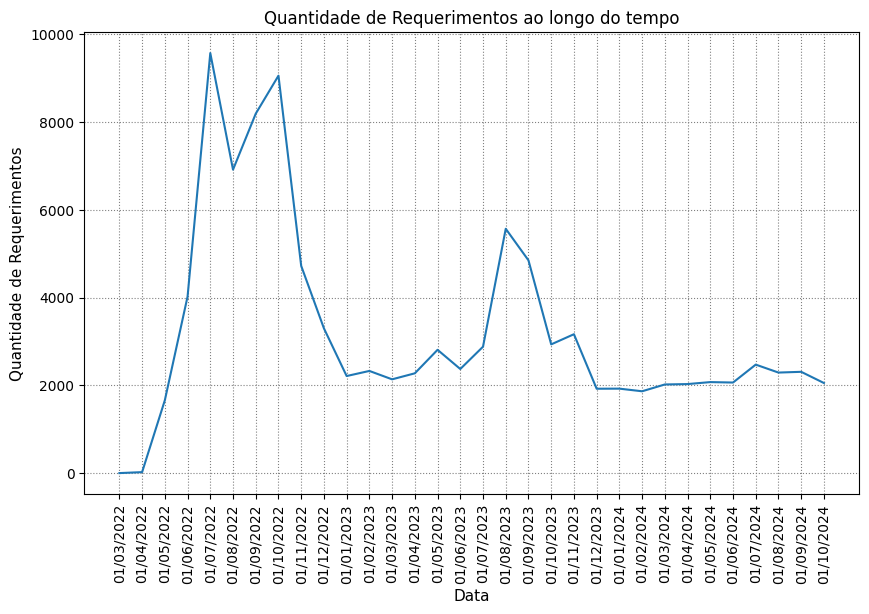

In [73]:
plt.figure(figsize=(10,6))
plt.plot(df['Data'], df['Quantidade'])
plt.grid(linestyle=':',color='gray',linewidth=0.8)
plt.title('Quantidade de Requerimentos ao longo do tempo')
plt.xlabel('Data',fontsize=11)
plt.ylabel('Quantidade de Requerimentos',fontsize=11)
plt.xticks(rotation=90)
plt.show()

Gráfico da distribuição de frequência dos valores. A grande maioria dos valores está presente no intervalo de 2000 a 4000 requerimentos.

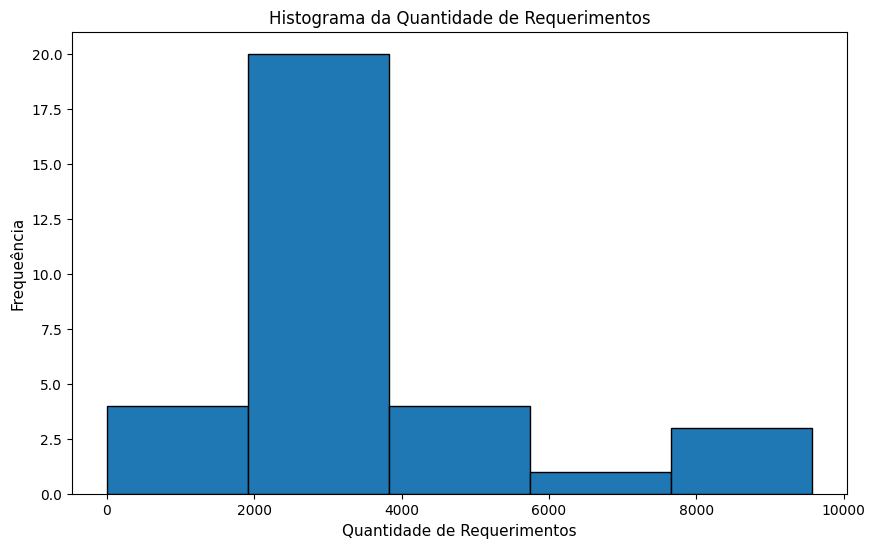

In [74]:
plt.figure(figsize=(10,6))
plt.hist(df['Quantidade'],bins=5, edgecolor='black')
plt.title('Histograma da Quantidade de Requerimentos')
plt.xlabel('Quantidade de Requerimentos',fontsize=11)
plt.ylabel('Frequeência',fontsize=11)
plt.show()

Teste Dickey-Fuller aumentado, utilizando para verificar a estacionaridade da série temporal. O p-valor elevado demonstra que a série temporal não é estacionária.

In [75]:
resultado = adfuller(df['Quantidade'])
print("Estatística ADF:", resultado[0])
print("p-valor:", resultado[1])
print("Número de lags usados:", resultado[2])
print("Número de observações:", resultado[3])
print("Valores críticos:")
for key, value in resultado[4].items():
    print(f'    {key}: {value}')

Estatística ADF: -0.64432944333612
p-valor: 0.8606475623209464
Número de lags usados: 10
Número de observações: 21
Valores críticos:
    1%: -3.7883858816542486
    5%: -3.013097747543462
    10%: -2.6463967573696143


Teste Dickey-Fuller aumentado após transformação logarítmica dos valores que, conforme p-valor, tornou a série estacionária.

In [76]:
log_serie = np.log(df['Quantidade'])
resultado_log = adfuller(log_serie)
print("Estatística ADF:", resultado_log[0])
print("p-valor:", resultado_log[1])
print("Número de lags usados:", resultado_log[2])
print("Número de observações:", resultado_log[3])
print("Valores críticos:")
for key, value in resultado_log[4].items():
    print(f'    {key}: {value}')

Estatística ADF: -6.698314539492368
p-valor: 3.947620797913334e-09
Número de lags usados: 0
Número de observações: 31
Valores críticos:
    1%: -3.661428725118324
    5%: -2.960525341210433
    10%: -2.6193188033298647


Atribuição ao dataframe dos valores que passaram por transformação logarítmica e definição da coluna Data como índice.

In [77]:
df['Quantidade_log'] = log_serie
df.drop('Quantidade',axis=1,inplace=True)
df['Data'] = pd.to_datetime(df['Data'],format='%d/%m/%Y')
df.set_index('Data',inplace=True)

Demonstração das cinco primeiras linhas do dataframe.

In [78]:
df.head()

,Quantidade_log
Data,
2022-03-01,1.6094
2022-04-01,3.2958
2022-05-01,7.4164
2022-06-01,8.3000
2022-07-01,9.1662


Atribuição da coluna "Quantidade_log" à variável y.

In [79]:
y = df['Quantidade_log']

Aplicação da técnica MinMaxScaler para normalização dos dados, colocando-os em um intervalo entre 0 e 1 e atribuindo-os à variável y_scaled.

In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

Divisão dos dados entre treino e teste em uma proporção aproximada de, respectivamente, 80% e 20%.

In [81]:
train_end_date = pd.to_datetime('2024-05-01') -  pd.Timedelta(days=1)
y_train = y[:train_end_date]
y_test = y[train_end_date:]

Criação de uma função que reverte a transformação logarítmica através da exponenciação e calcula o erro quadrático médio com os dados na escala original.

In [82]:
def calculate_mse_original_scale(forecast, y_test):
    forecast_original = np.exp(forecast)
    y_test_original = np.exp(y_test)
    mse = mean_squared_error(y_test_original, forecast_original)
    return mse

Criação de dois dicionários vazios, results e forecasts, que serão utilizados para armazenar, respectiva, o erro quadrático médio e os valores previstos.

In [83]:
results = {}
forecasts = {}

Função para elevação ao quadrado e reversão da transformação logarítmica.

In [84]:
def reverse_transformation(data):
    return np.exp(data)

Criação de uma função que aplica o algoritmo de previsão auto arima. Este modelo faz a seleção automática dos valores p (autoregressiva), d (diferenciação) e q (média móvel). Os dados não apresentam sazonalidade, mas possui tendência e ambas características foram consideradas nos parâmetros utilizados. Os valores da previsão são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.




In [85]:
def arima_model(y_train, y_test):

    model = auto_arima(
        y_train,
        seasonal=False,
        stepwise=True,
        trace=True
    )


    model_fit = model.fit(y_train)


    forecast = model_fit.predict(n_periods=len(y_test))


    mse = calculate_mse_original_scale(forecast, y_test)

    return forecast, mse


forecast, mse = arima_model(y_train, y_test)
results['ARIMA'] = mse
forecasts['ARIMA'] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=75.670, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.703, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=79.402, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=73.143, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=76.000, Time=0.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=75.143, Time=2.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=3.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=74.831, Time=1.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=76.442, Time=1.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=72.346, Time=0.48 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=75.226, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=73.508, Time=2.04 sec
 ARIMA(1

Criação de uma função que aplica o algoritmo de suavização exponencial, que atribui pesos maiores aos dados mais recentes. Os valores da previsão são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.


In [86]:
def exp_smoothing(y_train, y_test):
    model = ExponentialSmoothing(y_train, seasonal=None, trend='add')
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(y_test))
    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = exp_smoothing(y_train, y_test)
results['Exponential Smoothing'] = mse
forecasts['Exponential Smoothing'] = forecast

Definição de uma função que realiza a previsão através do algoritmo XGBoost, utilizando-se do GridSearchCV para a definição dos melhores parâmetros. O XGBoost é baseado em árvores de decisão e utiliza o princípio de boosting para melhorar a precisão das previsões. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.

---



In [87]:
def xgboost_model(y_train, y_test):
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
    grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(np.arange(len(y_train)).reshape(-1, 1), y_train)
    print("Melhores hiperparâmetros para o XGBoost:", grid_search.best_params_)
    forecast = grid_search.predict(np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1))
    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = xgboost_model(y_train, y_test)
results['XGBoost'] = mse
forecasts['XGBoost'] = forecast

Melhores hiperparâmetros para o XGBoost: {'max_depth': 3, 'n_estimators': 50}


Definição de uma função que realiza a previsão através do algoritmo LightGBM, baseado em boosting por gradiente. Utilizou-se do GridSearchCV para a definição dos melhores parâmetros. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.


In [88]:
def lightgbm_model(y_train, y_test):
    param_grid = {'n_estimators': [50, 100, 200], 'num_leaves': [20, 31, 50]}
    grid_search = GridSearchCV(LGBMRegressor(verbose=-1), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(np.arange(len(y_train)).reshape(-1, 1), y_train)
    print("Melhores hiperparâmetros para o LightGBM:", grid_search.best_params_)
    forecast = grid_search.predict(np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1))
    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = lightgbm_model(y_train, y_test)
results['LightGBM'] = mse
forecasts['LightGBM'] = forecast

Melhores hiperparâmetros para o LightGBM: {'n_estimators': 50, 'num_leaves': 20}


Definição de uma função que realiza a previsão através do algoritmo Random Forest Regressor, baseado em ensemble learning e na utilização de uma coleção de árvores de decisão para realizar a regresão. É utilizado o GridSearchCV para a definição dos melhores parâmetros. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.


In [89]:
def random_forest_model(y_train, y_test):
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(np.arange(len(y_train)).reshape(-1, 1), y_train)
    print("Melhores hiperparâmetros para o Random Forest:", grid_search.best_params_)
    forecast = grid_search.predict(np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1))
    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = random_forest_model(y_train, y_test)
results['Random Forest'] = mse
forecasts['Random Forest'] = forecast

Melhores hiperparâmetros para o Random Forest: {'max_depth': 10, 'n_estimators': 100}


Definição de uma função que realiza a previsão através do algoritmo Linear Regression, que busca modelar a relação entre uma variável dependente (alvo) e uma ou mais variáveis independentes (features). O algoritmo busca ajustar uma linha que minimize o erro entre as previsões e os valores reais. É utilizado o GridSearchCV para a definição dos melhores parâmetros. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.

In [90]:
def linear_regression_model(y_train, y_test):

    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    param_grid = {'fit_intercept': [True, False]}
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(np.arange(len(y_train)).reshape(-1, 1), y_train_scaled)
    print("Melhores hiperparâmetros para a Regressão Linear:", grid_search.best_params_)


    forecast_scaled = grid_search.predict(np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1))


    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = linear_regression_model(y_train, y_test)
results['Linear Regression'] = mse
forecasts['Linear Regression'] = forecast

Melhores hiperparâmetros para a Regressão Linear: {'fit_intercept': False}


Definição de uma função que realiza a previsão através do algoritmo Support Vector Regression (SVR), que busca ajustar uma função de regressão para minimizar o erro. É utilizado o GridSearchCV para a definição dos melhores parâmetros. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.

In [91]:
def svm_model(y_train, y_test):
    param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(np.arange(len(y_train)).reshape(-1, 1), y_train)
    print("Melhores hiperparâmetros para o SVR:", grid_search.best_params_)
    forecast = grid_search.predict(np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1))
    mse = calculate_mse_original_scale(forecast, y_test)
    return forecast, mse

forecast, mse = svm_model(y_train, y_test)
results['Support Vector Regression'] = mse
forecasts['Support Vector Regression'] = forecast

Melhores hiperparâmetros para o SVR: {'C': 0.1, 'gamma': 'auto'}


Definição de uma função que realiza a previsão através do algoritmo Long Short-Term Memory (LSTM), uma rede neural recorrente (RNN) projetada para lidar com o problema do desvanecimento do gradiente, que ocorre quando redes neurais tentam aprender dependências de longo prazo em dados sequencias. Os resultados da projeção são atribuídos ao dicionário forecasts e o erro quadrático médio é atribuído ao dicionário results.

In [92]:
def lstm_model(y_train, y_test):

    y_scaled_train = scaler.fit_transform(y_train.values.reshape(-1, 1))


    X_train = []
    y_lstm_train = []
    for i in range(1, len(y_scaled_train)):
        X_train.append(y_scaled_train[i-1:i, 0])
        y_lstm_train.append(y_scaled_train[i, 0])

    X_train = np.array(X_train).reshape(-1, 1, 1)
    y_lstm_train = np.array(y_lstm_train)


    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    model.fit(X_train, y_lstm_train, epochs=100, verbose=0)

    predictions = []
    X_test = y_scaled_train[-1].reshape(1, 1, 1)
    for _ in range(len(y_test)):
        pred = model.predict(X_test)
        predictions.append(pred[0, 0])
        X_test = np.array([[pred[0, 0]]]).reshape(1, 1, 1)


    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    mse = calculate_mse_original_scale(forecast, y_test)
    return predictions, mse

forecast, mse = lstm_model(y_train, y_test)
results['LSTM'] = mse
forecasts['LSTM'] = forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Criação de uma função que realiza a projeção através de um método ensemble. O ensemble utiliza a média dos valores dos demais modelos para realizar a previsão.

In [93]:
def ensemble_model(*forecasts):
    ensemble_forecast = np.mean(np.column_stack(forecasts), axis=1)
    mse = calculate_mse_original_scale(ensemble_forecast, y_test)
    return ensemble_forecast, mse


Aplicação das funções de projeção criadas anteriormente com base nos valores de treino e teste.

In [94]:
arima_forecast, _ = arima_model(y_train, y_test)
exp_forecast, _ = exp_smoothing(y_train, y_test)
xgb_forecast, _ = xgboost_model(y_train, y_test)
lgbm_forecast, _ = lightgbm_model(y_train, y_test)
rf_forecast, _ = random_forest_model(y_train, y_test)
svm_forecast, _ = svm_model(y_train, y_test)
linear_forecast, _ = linear_regression_model(y_train, y_test)
lstm_forecast, _ = lstm_model(y_train, y_test)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=75.670, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.703, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=79.402, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=73.143, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=76.000, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=75.143, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=74.831, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=76.442, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=72.346, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=75.226, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=73.508, Time=0.23 sec
 ARIMA(1

Aplicação do algoritmo ensemble, atribuindo os valores da previsão ao dicionário forecasts e o erro quadrático médio ao dicionário results. O erro quadrático médio de cada modelo é demonstrado através de uma iteração no dicionário results.

In [95]:
ensemble_forecast, mse = ensemble_model(
    arima_forecast, exp_forecast, xgb_forecast, lgbm_forecast,
    rf_forecast, svm_forecast, linear_forecast, lstm_forecast
)

results['Ensemble'] = mse
forecasts['Ensemble'] = ensemble_forecast
for model_name, error in results.items():
    print(f"{model_name}: MSE = {error:.4f}")

ARIMA: MSE = 1298802.8687
Exponential Smoothing: MSE = 83106.3309
XGBoost: MSE = 60799.8851
LightGBM: MSE = 37651.1229
Random Forest: MSE = 57580.4109
Linear Regression: MSE = 1310055.5064
Support Vector Regression: MSE = 182422.0901
LSTM: MSE = 182422.0901
Ensemble: MSE = 24949.0918


O dicionário contendo o erro quadrático médio é transformado em um dataframe e os valores são demonstrados em ordem crescente. Os melhores modelos, conforme erro quadrático médio, são o Ensemble, LightGBM, XGBoost, Random Forest Regressor e Exponential Smoothing, com erros mais significativos a partir do Support Vector Regression.

In [96]:
pd.options.display.float_format = '{:.4f}'.format

df_results_mse = pd.DataFrame(list(results.items()), columns=['Model', 'MSE'])
df_results_mse_sorted = df_results_mse.sort_values(by='MSE', ascending=True)
print(df_results_mse_sorted)

                       Model          MSE
8                   Ensemble   24949.0918
3                   LightGBM   37651.1229
4              Random Forest   57580.4109
2                    XGBoost   60799.8851
1      Exponential Smoothing   83106.3309
6  Support Vector Regression  182422.0901
7                       LSTM  182422.0901
0                      ARIMA 1298802.8687
5          Linear Regression 1310055.5064


As previsões contidas no dicionário forecasts são transformadas em um dataframe e os valores são elevados ao quadrado para reverter a transformação logarítmica.

In [97]:
forecasts = pd.DataFrame(forecasts)
forecasts = forecasts.apply(np.exp)
forecasts

,ARIMA,Exponential Smoothing,XGBoost,LightGBM,Random Forest,Linear Regression,Support Vector Regression,LSTM,Ensemble
2024-05-01,1532.0561,2134.7818,2023.8032,2100.3161,2032.4959,3209.9079,2532.6957,2539.0874,2222.7174
2024-06-01,1206.6883,2231.5677,2023.8032,2100.3161,2032.4959,3262.7027,2627.0019,2858.5977,2219.3915
2024-07-01,1091.9975,2332.7417,2023.8032,2100.3161,2032.4959,3316.3657,2631.8137,3045.6191,2227.2883
2024-08-01,1008.9024,2438.5026,2023.8032,2100.3161,2032.4959,3370.9114,2631.8462,3150.8650,2231.4811
2024-09-01,947.5667,2549.0585,2023.8032,2100.3161,2032.4959,3426.3542,2631.8462,3208.8550,2235.6810
2024-10-01,901.6193,2664.6267,2023.8032,2100.3161,2032.4959,3482.7089,2631.8462,3240.4500,2241.1895


Demonstração dos valores previstos pelos distintos modelos utilizados.

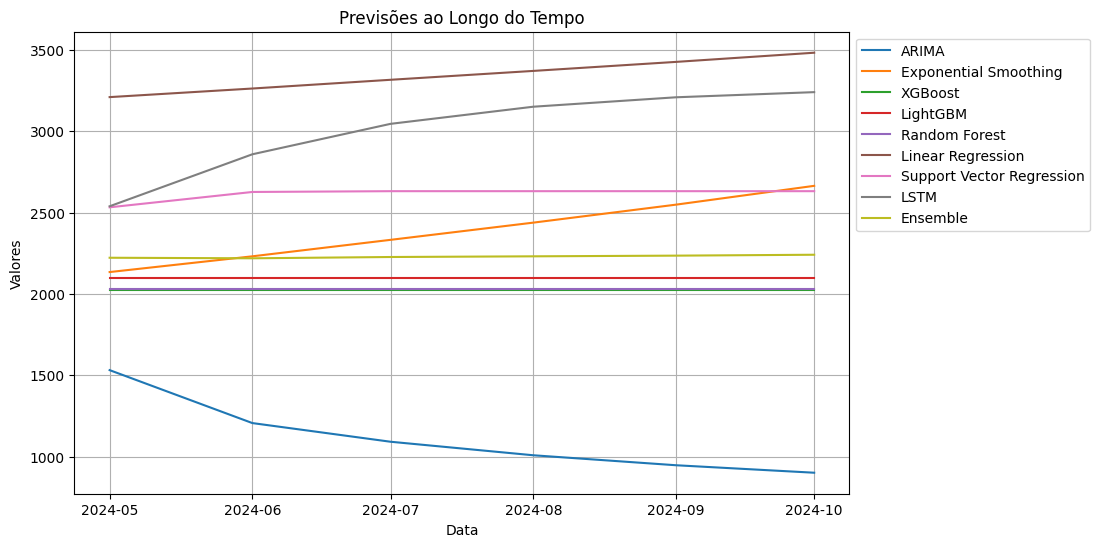

In [98]:
plt.figure(figsize=(10,6))

for coluna in forecasts.columns:
    plt.plot(forecasts.index, forecasts[coluna], label=coluna)


plt.title('Previsões ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

Com base nos resultados apresentados pelos melhores modelos (Ensemble à Suavização Exponencial), é possível perceber uma tendência relativamente estável da quantidade de requerimentos, o que de fato ocorreu conforme base de teste utilizada como comparativo. Tal resultado também está em linha com que é esperado pelo Programa de Transferência de Renda, visto não haver mais o prognóstico de inclusão de novos municípios como passíveis de receber o benefício, fator responsável pelas elevadas alterações nas quantidades mensais de requerimentos ocorridas no passado. A eficácia dos modelos ora apresentados levanta expectativas relacionadas a projeção de meses futuros, cujos resultados poderão ser utilizados como embasamento às decisões tomadas pela gerência do Programa.